In [12]:
import os, sys
os.environ["CUDA_VISIBLE_DEVICES"]="0,1"
import datetime
import numpy as np
import pandas as pd

import matplotlib.cm  as cm
import matplotlib.patches as mpatch
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

from sklearn.manifold import TSNE
from sklearn.mixture import GaussianMixture
import tensorflow as tf
from tensorflow import keras

sys.path.append( '..' )
from utils import LP_PSDs, LP_datos, plot_LP_list

In [ ]:
tf.config.list_physical_devices()
# %load_ext tensorboard

Hasta ahora hemos visto que la combinación TSNE+GMM nos da unos resultados que permite entrenar un clasificador con muy buena precision.
Sin embargo, no hemos discutido sobre la extracción de parametros que, de alguna forma, es la base de nuestros resultados.

EL objetivo de este cuaderno es aplicar Redes Nauronales, y en particular AutoEncoders, para la extracción de parametros que permita mejorar la selección de clusters en el TSNE+GMM. 

Vamos a trabajar en el dominio espectral de la señal. Así que aplicaremos una nfft que permita describir el contenido espectral de todas las señales con el mismo tamaño. De esta forma, cada señal vendra parametrizada por su PSD que tiene un tamaño dado por la fq_size. 

In [2]:
x_all, (x_train, x_test) = LP_PSDs(test_size=0.5)
fq_size = x_train.shape[1]

X_all = x_all.reshape(x_all.shape[0], fq_size, 1)
X_test = x_test.reshape(x_test.shape[0], fq_size, 1)
X_train =x_train.reshape(x_train.shape[0], fq_size, 1)

## Modelos

### 1. Simple AutoEncoder

2021-11-15 00:21:58.007020: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-15 00:21:58.033197: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-15 00:21:58.033417: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-15 00:21:58.033915: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

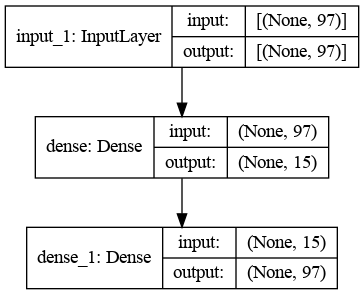

In [3]:
keras.backend.clear_session()
input_img = keras.layers.Input(shape=(fq_size,))
encoded = keras.layers.Dense(15, activation='relu')(input_img)
decoded = keras.layers.Dense(fq_size, activation='sigmoid')(encoded)
AE = keras.models.Model(input_img, decoded)
keras.utils.plot_model(AE, show_shapes=True)

2021-11-15 00:22:01.155093: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/200
14/14 [==============================] - 1s 11ms/step - loss: 0.6844 - val_loss: 0.6713
Epoch 2/200
14/14 [==============================] - 0s 4ms/step - loss: 0.6590 - val_loss: 0.6395
Epoch 3/200
14/14 [==============================] - 0s 3ms/step - loss: 0.6205 - val_loss: 0.5914
Epoch 4/200
14/14 [==============================] - 0s 3ms/step - loss: 0.5657 - val_loss: 0.5312
Epoch 5/200
14/14 [==============================] - 0s 3ms/step - loss: 0.5046 - val_loss: 0.4738
Epoch 6/200
14/14 [==============================] - 0s 3ms/step - loss: 0.4528 - val_loss: 0.4329
Epoch 7/200
14/14 [==============================] - 0s 3ms/step - loss: 0.4182 - val_loss: 0.4083
Epoch 8/200
14/14 [==============================] - 0s 3ms/step - loss: 0.3977 - val_loss: 0.3943
Epoch 9/200
14/14 [==============================] - 0s 3ms/step - loss: 0.3861 - val_loss: 0.3857
Epoch 10/200
14/14 [==============================] - 0s 3ms/step - loss: 0.3786 - val_loss: 0.3799
Epoch 11

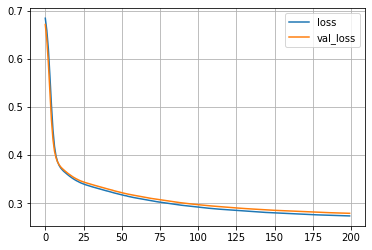

In [4]:
AE.compile(optimizer='adam', loss='binary_crossentropy')
history = AE.fit(x_train, x_train,
                epochs=200,
                batch_size=40,
                shuffle=True,
                validation_data=(x_test, x_test)
                )
pd.DataFrame(history.history).plot()
plt.grid(True)
plt.show()

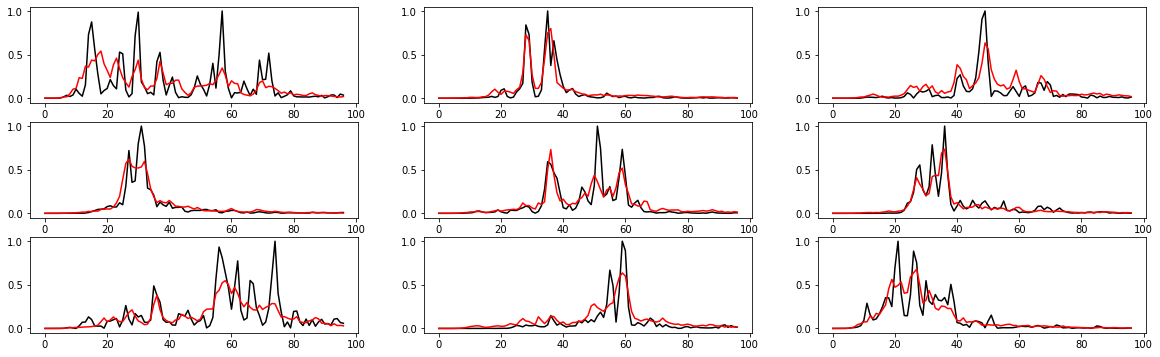

In [5]:
x_pred = AE.predict(x_test)
plt.figure(figsize=(20, 6))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    n = np.random.randint(0, x_test.shape[0])
    ax.plot(x_test[n,:], color='k')
    ax.plot(x_pred[n,:], color='r')

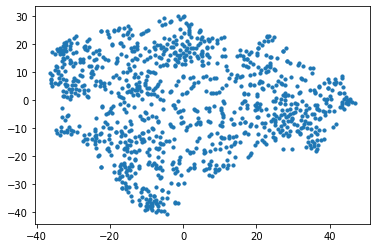

In [6]:
encoder = keras.models.Model(input_img, encoded)
# encoded_imgs = encoder.predict(x_test)
tsne = TSNE(init="pca")
X_valid_2D = tsne.fit_transform(encoder.predict(x_all))
plt.scatter(X_valid_2D[:,0], X_valid_2D[:,1], s=10)

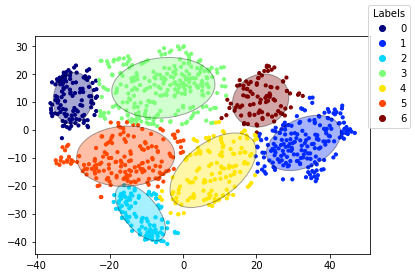

In [7]:
n = 7
gmm = GaussianMixture(n_components=n, n_init=10).fit(X_valid_2D)
labels = gmm.predict(X_valid_2D)
prob = gmm.predict_proba(X_valid_2D)
print(' Akaike information criterion (AIC): ', f'{gmm.aic(X_valid_2D):.0f}')
print(' Bayesian information criterion (BIC): ', f'{gmm.bic(X_valid_2D):.0f}')

fig, ax = plt.subplots(1,1)
norm = mcolors.Normalize(0, n-1)
ax.scatter(X_valid_2D[:,0], X_valid_2D[:,1], c=labels, cmap='jet', norm=norm, s=10)
h = [plt.Line2D([0], [0], linestyle="none", marker="o", c=cm.get_cmap('jet')(norm(c)), label=c, alpha=1) for c in range(n)]
fig.legend(h, range(n), title='Labels')

# plot ellipses
for n, (mean, covar) in enumerate(zip(gmm.means_, gmm.covariances_)):
    v, w = np.linalg.eigh(covar)
    v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
    u = w[0] / np.linalg.norm(w[0])
    angle = np.arctan(u[1] / u[0])
    angle = 180.0 * angle / np.pi
    ell = mpatch.Ellipse(mean, v[0], v[1], 180.0 + angle, ec='k', color=cm.get_cmap('jet')(norm(n)))
    ell.set_clip_box(ax.bbox)
    ell.set_alpha(0.35)
    ax.add_artist(ell)

[285 228 304]


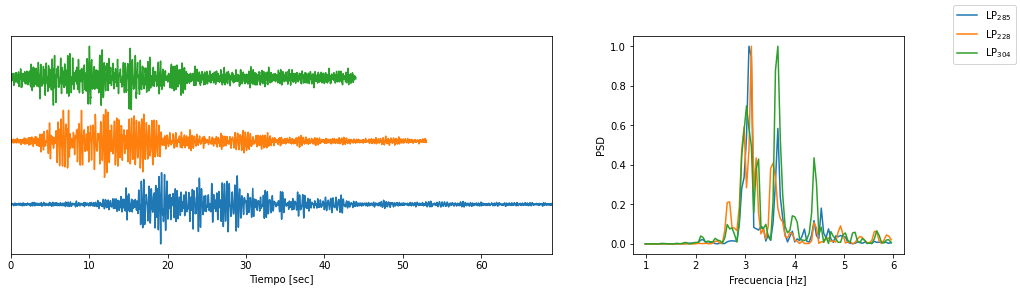

In [29]:
k_label = 0
n_LPs = 3
gen = LP_datos()

k_index, = np.where(labels==k_label)
LP_idxs_a = k_index[np.random.choice(k_index.shape[0], n_LPs)]
print(LP_idxs_a)
plot_LP_list(map(gen.get, LP_idxs_a))

### 2.RNN AutoEncoder (No funciona bien)

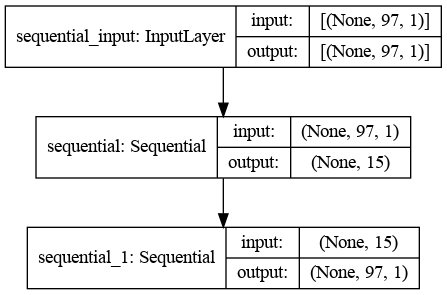

In [30]:
keras.backend.clear_session()
recurrent_encoder = keras.models.Sequential([
    keras.layers.LSTM(50, return_sequences=True, activation='relu', input_shape=[fq_size, 1]),
    keras.layers.LSTM(15, activation='relu')
])
recurrent_decoder = keras.models.Sequential([
    keras.layers.RepeatVector(fq_size, input_shape=[15]),
    keras.layers.LSTM(50, activation='relu', return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(1, activation="sigmoid"))
])
rnn_ae = keras.models.Sequential([recurrent_encoder, recurrent_decoder])
keras.utils.plot_model(rnn_ae, show_shapes=True)

Epoch 1/100
17/17 [==============================] - 6s 258ms/step - loss: 0.6653 - val_loss: 0.5914
Epoch 2/100
17/17 [==============================] - 4s 242ms/step - loss: 0.5058 - val_loss: 0.4390
Epoch 3/100
17/17 [==============================] - 4s 249ms/step - loss: 0.4158 - val_loss: 0.4060
Epoch 4/100
17/17 [==============================] - 4s 254ms/step - loss: 0.4008 - val_loss: 0.3988
Epoch 5/100
17/17 [==============================] - 4s 263ms/step - loss: 0.3934 - val_loss: 0.3906
Epoch 6/100
17/17 [==============================] - 4s 266ms/step - loss: 0.3850 - val_loss: 0.3820
Epoch 7/100
17/17 [==============================] - 4s 259ms/step - loss: 0.3766 - val_loss: 0.3736
Epoch 8/100
17/17 [==============================] - 4s 259ms/step - loss: 0.3679 - val_loss: 0.3633
Epoch 9/100
17/17 [==============================] - 4s 260ms/step - loss: 0.3567 - val_loss: 0.3529
Epoch 10/100
17/17 [==============================] - 4s 258ms/step - loss: 0.3471 - val_lo

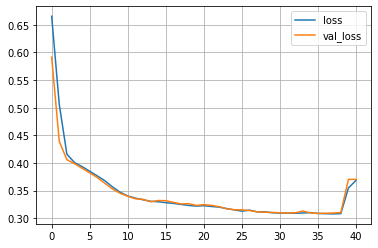

In [31]:
rnn_ae.compile(optimizer='adam', loss='binary_crossentropy')
history = rnn_ae.fit(X_train, X_train,
                epochs=100,
                batch_size=32,
                validation_data=(X_test, X_test),
                callbacks=[keras.callbacks.EarlyStopping(patience=5)]
                )
pd.DataFrame(history.history).plot()
plt.grid(True)
plt.show()

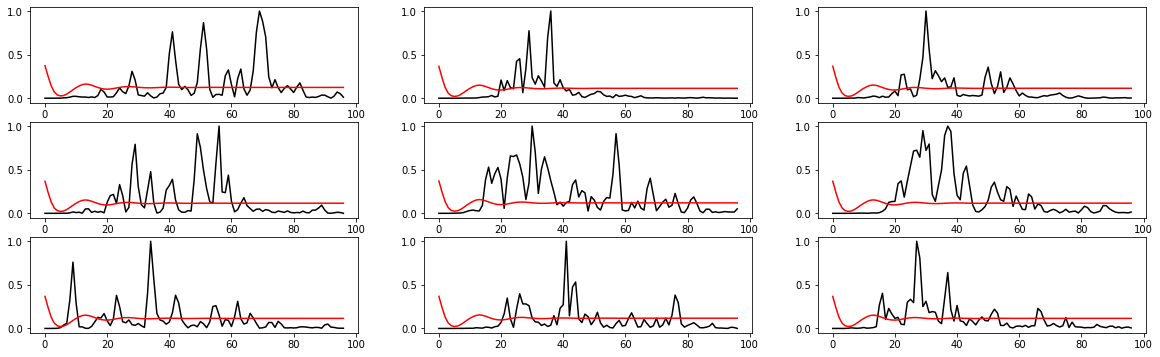

In [37]:
x_pred = rnn_ae.predict(X_test)
plt.figure(figsize=(20, 6))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    n = np.random.randint(0, x_test.shape[0])
    ax.plot(x_test[n,:], color='k')
    ax.plot(x_pred[n,:,0], color='r')

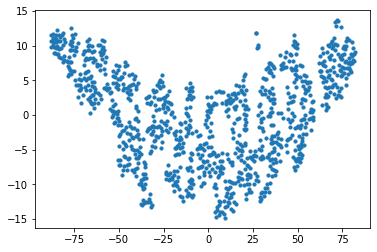

In [39]:
encoded_imgs = recurrent_encoder.predict(X_all)
tsne = TSNE(init='pca')
X_valid_2D = tsne.fit_transform(encoded_imgs)
plt.scatter(X_valid_2D[:,0], X_valid_2D[:,1], s=10)

### 3.Deep AutoEncoder

In [41]:
keras.backend.clear_session()
dropout_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=(fq_size,)),
    keras.layers.Dropout(0.25),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(13, activation="selu")
])
dropout_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[13]),
    keras.layers.Dense(fq_size, activation="sigmoid")
])
dropout_ae = keras.models.Sequential([dropout_encoder, dropout_decoder])
keras.utils.plot_model(dropout_ae, show_shapes=True)
dropout_ae.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 13)                11113     
_________________________________________________________________
sequential_1 (Sequential)    (None, 97)                11197     
Total params: 22,310
Trainable params: 22,310
Non-trainable params: 0
_________________________________________________________________


Epoch 1/100
17/17 [==============================] - 0s 8ms/step - loss: 0.5770 - val_loss: 0.4284
Epoch 2/100
17/17 [==============================] - 0s 3ms/step - loss: 0.3780 - val_loss: 0.3526
Epoch 3/100
17/17 [==============================] - 0s 3ms/step - loss: 0.3428 - val_loss: 0.3383
Epoch 4/100
17/17 [==============================] - 0s 3ms/step - loss: 0.3327 - val_loss: 0.3297
Epoch 5/100
17/17 [==============================] - 0s 3ms/step - loss: 0.3248 - val_loss: 0.3219
Epoch 6/100
17/17 [==============================] - 0s 3ms/step - loss: 0.3190 - val_loss: 0.3161
Epoch 7/100
17/17 [==============================] - 0s 3ms/step - loss: 0.3138 - val_loss: 0.3116
Epoch 8/100
17/17 [==============================] - 0s 3ms/step - loss: 0.3099 - val_loss: 0.3076
Epoch 9/100
17/17 [==============================] - 0s 3ms/step - loss: 0.3058 - val_loss: 0.3041
Epoch 10/100
17/17 [==============================] - 0s 3ms/step - loss: 0.3032 - val_loss: 0.3005
Epoch 11/

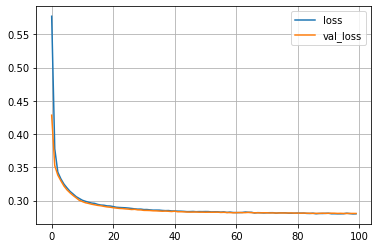

In [42]:
dropout_ae.compile(loss="binary_crossentropy", optimizer='adam')
# logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
# tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
# %tensorboard --logdir logs
history = dropout_ae.fit(x_train, x_train, epochs=100,
                         validation_data=(x_test, x_test))
pd.DataFrame(history.history).plot()
plt.grid(True)
plt.show()

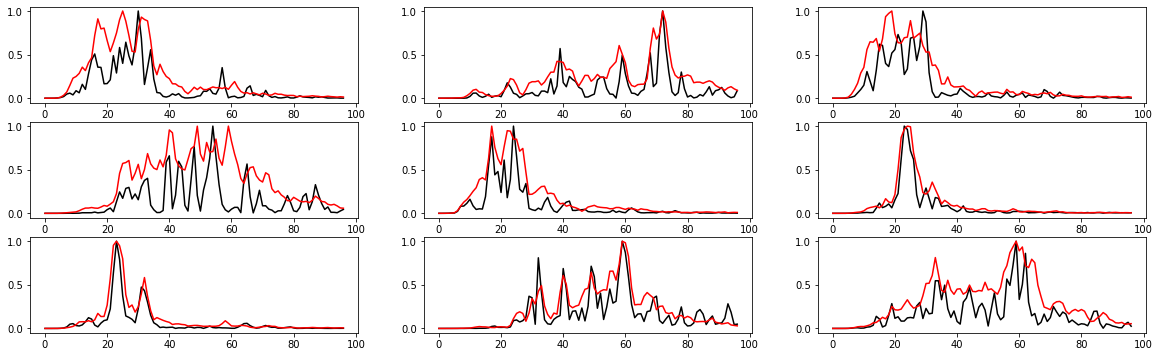

In [44]:
x_pred = dropout_ae.predict(x_test)
plt.figure(figsize=(20, 6))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    n = np.random.randint(0, x_test.shape[0])
    ax.plot(x_test[n,:], color='k')
    ax.plot(x_pred[n,:]/x_pred[n,:].max(), color='r')

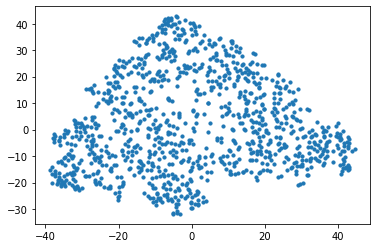

In [45]:
tsne = TSNE(init='pca')
X_valid_2D = tsne.fit_transform(dropout_encoder.predict(x_all))
plt.scatter(X_valid_2D[:,0], X_valid_2D[:,1], s=10)

 Akaike information criterion (AIC):  17545
 Bayesian information criterion (BIC):  17748


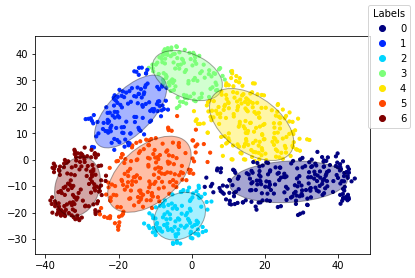

In [47]:
n = 7
gmm = GaussianMixture(n_components=n, n_init=10).fit(X_valid_2D)
labels = gmm.predict(X_valid_2D)
prob = gmm.predict_proba(X_valid_2D)
print(' Akaike information criterion (AIC): ', f'{gmm.aic(X_valid_2D):.0f}')
print(' Bayesian information criterion (BIC): ', f'{gmm.bic(X_valid_2D):.0f}')

fig, ax = plt.subplots(1,1)
norm = mcolors.Normalize(0, n-1)
ax.scatter(X_valid_2D[:,0], X_valid_2D[:,1], c=labels, cmap='jet', norm=norm, s=10)
h = [plt.Line2D([0], [0], linestyle="none", marker="o", c=cm.get_cmap('jet')(norm(c)), label=c, alpha=1) for c in range(n)]
fig.legend(h, range(n), title='Labels')

# plot ellipses
for n, (mean, covar) in enumerate(zip(gmm.means_, gmm.covariances_)):
    v, w = np.linalg.eigh(covar)
    v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
    u = w[0] / np.linalg.norm(w[0])
    angle = np.arctan(u[1] / u[0])
    angle = 180.0 * angle / np.pi
    ell = mpatch.Ellipse(mean, v[0], v[1], 180.0 + angle, ec='k', color=cm.get_cmap('jet')(norm(n)))
    ell.set_clip_box(ax.bbox)
    ell.set_alpha(0.35)
    ax.add_artist(ell)

[148 499 164]


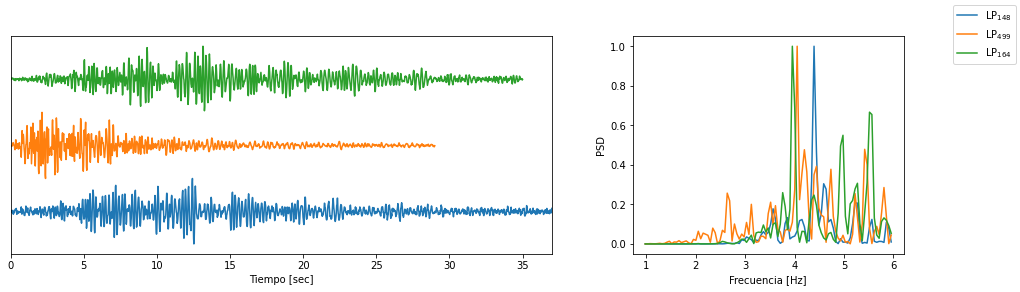

In [50]:
k_label = 2
n_LPs = 3
gen = LP_datos()

k_index, = np.where(labels==k_label)
LP_idxs_a = k_index[np.random.choice(k_index.shape[0], n_LPs)]
print(LP_idxs_a)
plot_LP_list(map(gen.get, LP_idxs_a))

### 4.Sparse Autoencoder

In [ ]:
keras.backend.clear_session()
sparse_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[fq_size,]),
    keras.layers.Dense(50, activation="selu"),
    keras.layers.Dense(10, activation="sigmoid"),
    keras.layers.ActivityRegularization(l1=1e-3)
])
sparse_decoder = keras.models.Sequential([
    keras.layers.Dense(50, activation="selu", input_shape=[10]),
    keras.layers.Dense(fq_size, activation="sigmoid")
])
sparse_ae = keras.models.Sequential([sparse_encoder, sparse_decoder], name='Sparse')
keras.utils.plot_model(sparse_ae, show_shapes=True)
sparse_ae.summary()

In [ ]:
sparse_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.0),
                     metrics=['accuracy'])
history = sparse_ae.fit(x_train, x_train, epochs=200,
                           validation_data=(x_test, x_test))

In [ ]:
x_pred = sparse_ae.predict(x_test)
plt.figure(figsize=(20, 6))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    n = np.random.randint(0, x_test.shape[0])
    ax.plot(x_test[n,:], color='k')
    ax.plot(x_pred[n,:]/x_pred[n,:].max(), color='r')

In [ ]:
tsne = TSNE()
X_valid_2D = tsne.fit_transform(sparse_encoder.predict(x_train))
plt.scatter(X_valid_2D[:,0], X_valid_2D[:,1], s=10)

### 5.Convolutional AutoEncoder (Difícil de implementar)

In [ ]:
keras.backend.clear_session()
conv_encoder = keras.models.Sequential([
    keras.layers.Conv1D(filters=25, kernel_size=4, activation="selu", input_shape=[fq_size,1], padding="same"),
    keras.layers.MaxPooling1D(2),
    keras.layers.Conv1D(filters=12, kernel_size=1, activation='selu', padding='same'),
    keras.layers.MaxPooling1D(2),
    keras.layers.Conv1D(filters=5, kernel_size=3, activation='selu', padding='same'),
    keras.layers.Flatten(),
    keras.layers.Dense(25, activation='selu'),
    keras.layers.Reshape([25,1])
])
conv_decoder = keras.models.Sequential([
    keras.layers.Conv1D(5, kernel_size=4, activation='selu', input_shape=[25, 1], padding='same'),
    keras.layers.UpSampling1D(2),
    keras.layers.Conv1D(12, kernel_size=4, activation='selu', padding='same'),
    keras.layers.UpSampling1D(2),
    keras.layers.Conv1D(25, kernel_size=4, activation='selu', padding='same'),
    keras.layers.Conv1D(1, kernel_size=4, activation='sigmoid')
])

# keras.utils.plot_model(conv_encoder, show_shapes=True)
conv_ae = keras.models.Sequential([conv_encoder, conv_decoder])
keras.utils.plot_model(conv_ae, show_shapes=True)
conv_ae.summary()

In [ ]:
conv_ae.compile(optimizer='adam', loss='binary_crossentropy')
history = conv_ae.fit(X_train, X_train,
            epochs=100,
            batch_size=32,
            shuffle=True,
            validation_data=(X_test, X_test))

In [ ]:
x_pred = conv_ae.predict(X_test)
plt.figure(figsize=(20, 6))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    n = np.random.randint(0, X_test.shape[0])
    ax.plot(x_test[n,:,0], color='k')
    ax.plot(x_pred[n,:,0], color='r')

In [ ]:
encoded_imgs = conv_encoder.predict(X_train)
tsne = TSNE()
X_valid_2D = tsne.fit_transform(encoded_imgs.reshape(encoded_imgs.shape[0],encoded_imgs.shape[1]))
plt.scatter(X_valid_2D[:,0], X_valid_2D[:,1], s=10)

### 6.Variational AutoEncoder

In [ ]:
keras.backend.clear_session()

K = keras.backend

class Sampling(keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return K.random_normal(tf.shape(log_var)) * K.exp(log_var / 2) + mean

In [ ]:
# encoder
inputs = keras.layers.Input(shape=(fq_size,), name='encoder_input')
x = keras.layers.Flatten()(inputs)
x = keras.layers.Dense(50, activation='relu')(x)
z_mean = keras.layers.Dense(15, name='z_mean')(x)
z_logvar = keras.layers.Dense(15, name='z_var')(x)
z = Sampling()([z_mean, z_logvar])
variational_encoder = keras.models.Model(inputs = [inputs], 
                                         outputs=[z_mean, z_logvar, z],
                                         name='variational_encoder')
variational_encoder.summary()
keras.utils.plot_model(variational_encoder, show_shapes=True)

In [ ]:
# decoder
latent_inputs = keras.layers.Input(shape=(15,))
x = keras.layers.Dense(50, activation='relu')(latent_inputs)
x = keras.layers.Dense(fq_size, activation='sigmoid')(x)
outputs = keras.layers.Reshape([fq_size,])(x)

# instanceo el modelo del decoder
variational_decoder = keras.models.Model(inputs=[latent_inputs], outputs=[outputs], name='variational_decoder')
variational_decoder.summary()
keras.utils.plot_model(variational_decoder, show_shapes=True)

In [ ]:
#el decoder es el modelo
#z es la variable definida como el tercer output del encoder
outputs = variational_decoder(z)

#autoencoder:
vae = keras.models.Model(inputs, outputs, name='vae_mlp')
keras.utils.plot_model(vae, show_shapes=True)

In [ ]:
latent_loss = -0.5 * K.sum(
    1 + z_logvar - K.exp(z_logvar) - K.square(z_mean),
    axis=-1)

vae.add_loss(K.mean(latent_loss) / fq_size ) #agregamos la función de perdida latente
vae.compile(loss="binary_crossentropy", optimizer="rmsprop")

In [ ]:
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10,
                                                  restore_best_weights=True)

hist = vae.fit(x_train, x_train,
        shuffle=True,
        epochs=200,
        batch_size=32,
        validation_data=(x_test, x_test),
        callbacks = [early_stopping_cb, tensorboard_callback])

In [ ]:
x_pred = vae.predict(x_test)
plt.figure(figsize=(20, 6))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    n = np.random.randint(0, x_test.shape[0])
    ax.plot(x_test[n,:], color='k')
    ax.plot(x_pred[n,:]/x_pred[n,:].max(), color='r')

In [ ]:
z_mean, z_var, z = variational_encoder.predict(x_test, batch_size=32)
plt.scatter(z_mean[:, 0], z_mean[:, 1])

## Clasificación

Seleccionar un modelo sencillo como puede ser el Deep o el Simple y utilizar sus capas para poder entrenar un clasificador.

Mejorará la perfomance de esta implementación si la comparamos con el logistico?

Si combinamos los parametros que tenemos junto con los que se obtiene de aplicar el autoencoder, mejora el TSNE+GMM?